# Read in Data

In [2]:
# ================================================================================
# Splitting training and test sets
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('WAGE2_2025_abridged.csv')

state= (540491669 + 540712391 + 540575497 + 540750669 + 540744934)   # replace this number with the sum of the student IDs for the members of your group

train = data.sample(frac=0.8, random_state=state)
test = data[data.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [3]:
train.head()

,wage,hours,IQ,KWW,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,lwage
0,1160,40,92,32,12,8,8,31,1,0,0,0,4,1.0,12.0,11.0,7.056175
1,722,55,113,36,16,8,1,38,0,0,1,1,1,2.0,8.0,NaN,6.582025
2,1160,40,84,35,12,17,2,38,1,0,0,0,4,2.0,16.0,12.0,7.056175
3,1000,50,104,36,16,11,8,30,1,0,0,1,1,1.0,12.0,11.0,6.907755
4,978,48,104,36,12,19,15,36,1,0,0,1,5,6.0,6.0,NaN,6.885510


In [4]:
train.isnull().sum()

wage         0
hours        0
IQ           0
KWW          0
educ         0
exper        0
tenure       0
age          0
married      0
black        0
south        0
urban        0
sibs         0
brthord     62
meduc       56
feduc      152
lwage        0
dtype: int64

### Forward Selected Data ###

In [5]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [6]:
df = train[['wage', 'educ', 'exper', 'hours', 'IQ', 'KWW', 'tenure', 'age', 'married', 'black', 'south', 'urban', 'sibs', 'meduc', 'feduc']]

In [7]:
model = forward_selected(df, 'wage')

adding educ increases adj_r2 from 0.000000 to 0.095299
adding KWW increases adj_r2 from 0.095299 to 0.138050
adding urban increases adj_r2 from 0.138050 to 0.161508
adding exper increases adj_r2 from 0.161508 to 0.181577
adding married increases adj_r2 from 0.181577 to 0.198835
adding IQ increases adj_r2 from 0.198835 to 0.215564
adding black increases adj_r2 from 0.215564 to 0.222994
adding tenure increases adj_r2 from 0.222994 to 0.228216
adding hours increases adj_r2 from 0.228216 to 0.230359
adding age increases adj_r2 from 0.230359 to 0.230768
adding south increases adj_r2 from 0.230768 to 0.230818
final model is wage ~ educ + KWW + urban + exper + married + IQ + black + tenure + hours + age + south + 1, with adj_r2 of 0.230818


# **Task 1**

### Numerical Summaries ###

In [8]:
numerical = train[['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age', 'sibs', 'meduc', 'feduc', 'lwage']]
numerical.describe().round(3)

,wage,hours,IQ,KWW,educ,exper,tenure,age,sibs,meduc,feduc,lwage
count,733.000,733.000,733.000,733.000,733.000,733.000,733.000,733.000,733.000,677.000,581.000,733.000
mean,962.921,44.082,101.854,35.801,13.501,11.487,7.235,33.034,2.898,10.703,10.176,6.787
std,402.656,7.134,14.500,7.656,2.182,4.456,5.089,3.122,2.199,2.843,3.317,0.412
min,200.000,20.000,54.000,12.000,9.000,1.000,0.000,28.000,0.000,0.000,0.000,5.298
25%,675.000,40.000,93.000,31.000,12.000,8.000,3.000,30.000,1.000,8.000,8.000,6.515
50%,910.000,40.000,103.000,37.000,12.000,11.000,7.000,33.000,2.000,12.000,10.000,6.813
75%,1186.000,48.000,112.000,41.000,16.000,15.000,11.000,36.000,4.000,12.000,12.000,7.078
max,3078.000,80.000,145.000,56.000,18.000,23.000,22.000,38.000,14.000,18.000,18.000,8.032


### Categorical summaries ###

In [9]:
tab=pd.crosstab(data['married'], columns="count");tab

col_0,count
married,
0,98
1,818


In [10]:
tab=pd.crosstab(data['black'], columns="count");tab

col_0,count
black,
0,807
1,109


In [11]:
tab=pd.crosstab(data['south'], columns="count");tab

col_0,count
south,
0,608
1,308


In [12]:
tab=pd.crosstab(data['urban'], columns="count");tab

col_0,count
urban,
0,256
1,660


In [13]:
tab=pd.crosstab(data['brthord'], columns="count");tab

col_0,count
brthord,
1.0,339
2.0,237
3.0,125
4.0,56
5.0,33
6.0,28
7.0,8
8.0,5
9.0,2


### Visuals ###

<Axes: xlabel='wage'>

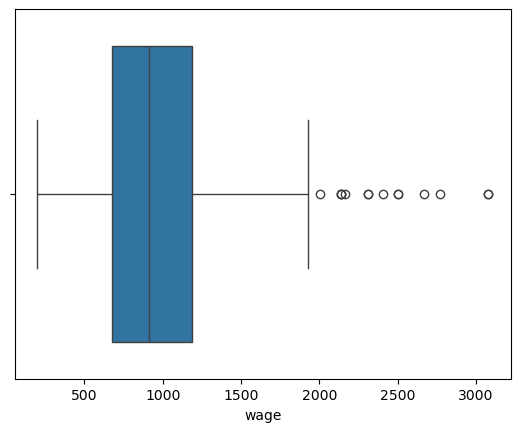

In [14]:
sns.boxplot(x=train['wage'])

<Axes: xlabel='married', ylabel='wage'>

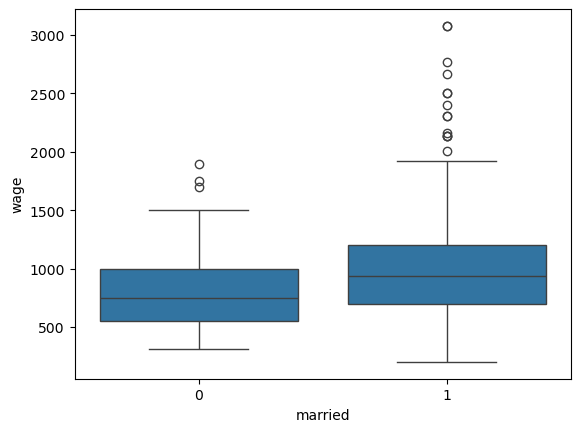

In [15]:
sns.boxplot(x='married', y='wage', data=train)

<Axes: xlabel='black', ylabel='wage'>

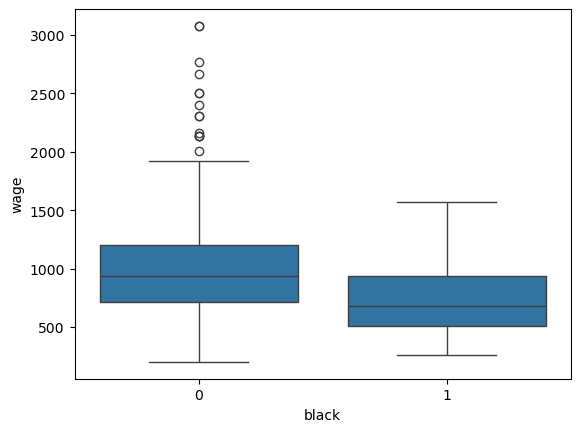

In [16]:
sns.boxplot(x='black', y='wage', data=train)

In [17]:
print(data.groupby('south')['wage'].mean())

south
0    1006.052632
1     868.993506
Name: wage, dtype: float64


In [18]:
print(data.groupby('urban')['wage'].mean())

urban
0     832.332031
1    1009.474242
Name: wage, dtype: float64


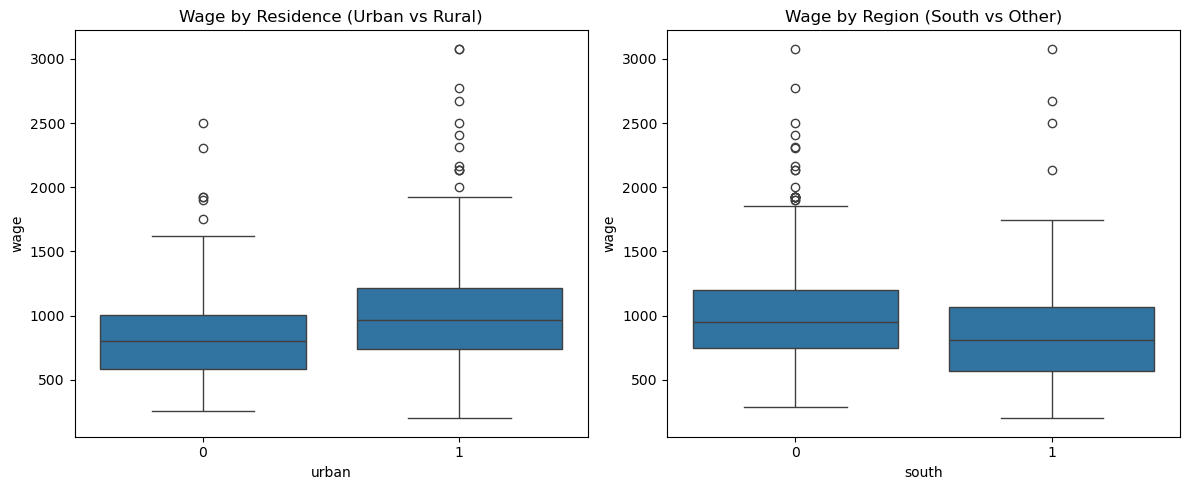

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Boxplot 1: Urban vs Rural
sns.boxplot(x='urban', y='wage', data=train, ax=axes[0])
axes[0].set_title("Wage by Residence (Urban vs Rural)")

# Boxplot 2: South vs Other
sns.boxplot(x='south', y='wage', data=train, ax=axes[1])
axes[1].set_title("Wage by Region (South vs Other)")

plt.tight_layout()
plt.savefig('region wage.png')
plt.show()

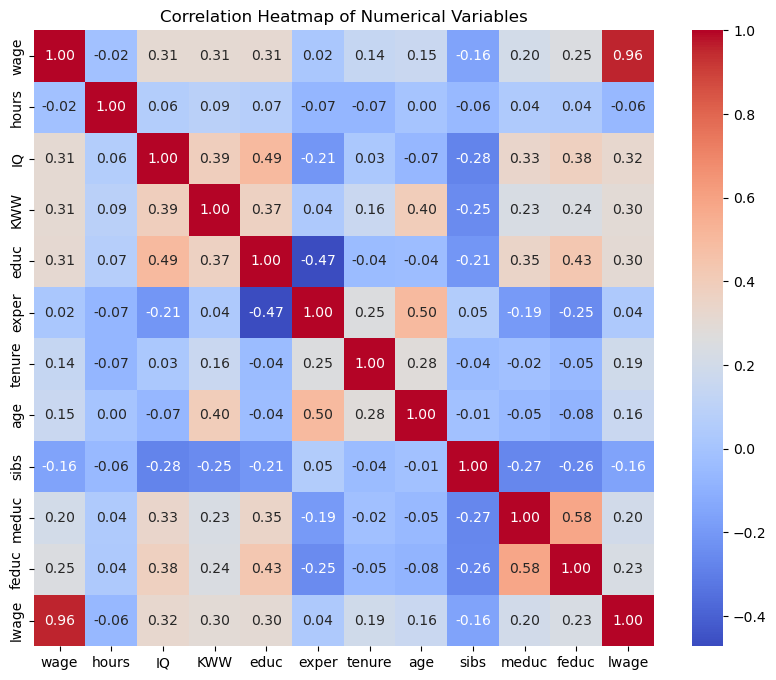

In [20]:
corr_matrix = numerical.corr()

plt.figure(figsize=(10, 8))  # Optional: adjust size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.savefig('heatmap all var.png')
plt.show()

### Comparing education in sub groups ###

In [21]:
print(data.groupby('south')['educ'].mean())

south
0    13.648026
1    13.185065
Name: educ, dtype: float64


In [22]:
print(data.groupby('urban')['educ'].mean())

urban
0    13.238281
1    13.590909
Name: educ, dtype: float64


In [23]:
print(data.groupby('black')['educ'].mean())

black
0    13.629492
1    12.477064
Name: educ, dtype: float64


In [24]:
print(data.groupby('married')['educ'].mean())

married
0    13.846939
1    13.449878
Name: educ, dtype: float64


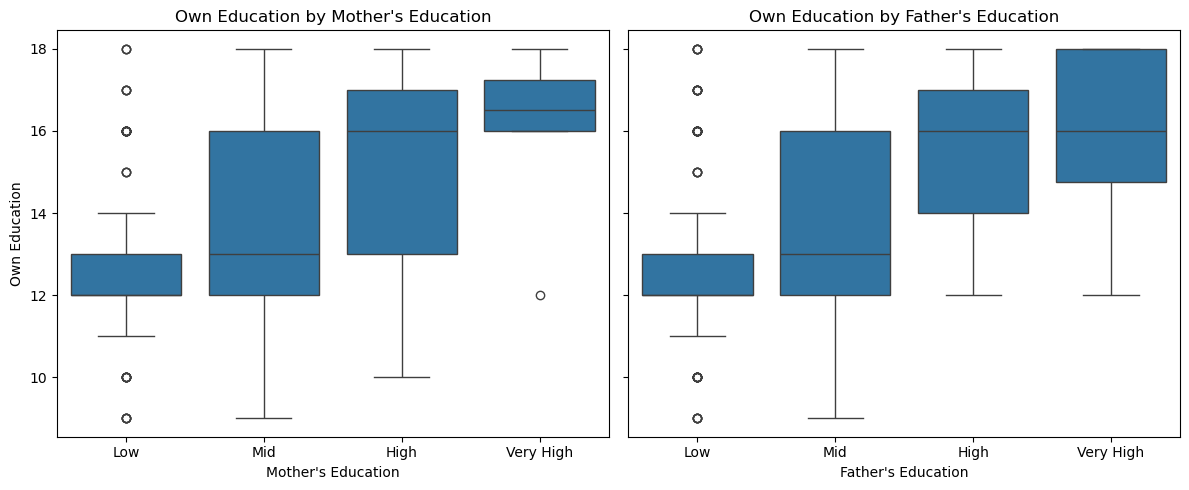

In [25]:
# Create bins for mother and father education
train['meduc_bin'] = pd.cut(train['meduc'], bins=[0, 8, 12, 16, 20], labels=['Low', 'Mid', 'High', 'Very High'])
train['feduc_bin'] = pd.cut(train['feduc'], bins=[0, 8, 12, 16, 20], labels=['Low', 'Mid', 'High', 'Very High'])

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Mother's education
sns.boxplot(x='meduc_bin', y='educ', data=train, ax=axes[0])
axes[0].set_title("Own Education by Mother's Education")
axes[0].set_xlabel("Mother's Education")
axes[0].set_ylabel("Own Education")

# Father's education
sns.boxplot(x='feduc_bin', y='educ', data=train, ax=axes[1])
axes[1].set_title("Own Education by Father's Education")
axes[1].set_xlabel("Father's Education")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('parental education vs own education.png')
plt.show()

# **Task 2**

### MLR of education and experience on wage

In [26]:
t2_model = smf.ols('wage ~ educ + exper', data=train)
t2_reg = t2_model.fit()
t2_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     55.84
Date:                Mon, 19 May 2025   Prob (F-statistic):           2.72e-23
Time:                        16:16:15   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    122.739     -2.353      0.019    -529.742     -47.814
educ          76.1294      7.216     10.550      0.000      61.963      90.296
exper         19.4915      3.534      5.516      0.000      12.554      26.429
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
#Extracting Fitted Values and Residuals from the Regression Model
t2_fit = t2_reg.fittedvalues
t2_resid = t2_reg.resid

In [28]:
t2_reg.mse_resid**0.5

375.5059302119657

In [29]:
t2_reg_rob = t2_model.fit(cov_type = 'HC0')
t2_reg_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     47.42
Date:                Mon, 19 May 2025   Prob (F-statistic):           4.36e-20
Time:                        16:16:15   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    128.375     -2.249      0.024    -540.388     -37.168
educ          76.1294      7.848      9.700      0.000      60.747      91.512
exper         19.4915      3.479      5.603      0.000      12.673      26.310
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

After correcting for potential heteroskedasticity using HC1 robust standard errors, the model’s coefficients remained statistically significant, suggesting that the key relationships are robust. However, the increase in standard errors and the lower F-statistic indicate that inference under standard OLS may have understated uncertainty.

In [30]:
t2_slr_educ_model = smf.ols('wage ~ educ', data=train).fit()
t2_slr_educ_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     78.11
Date:                Mon, 19 May 2025   Prob (F-statistic):           7.21e-18
Time:                        16:16:15   Log-Likelihood:                -5399.0
No. Observations:                 733   AIC:                         1.080e+04
Df Residuals:                     731   BIC:                         1.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    188.8699     88.719      2.129      0.034      14.695     363.045
educ          57.3342      6.487      8.838      0.000      44.598      70.070
==============================================================================
Omnibus:                      179.416   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.454
Skew:                           1.179   Prob(JB):                    2.95e-120
Kurtosis:                       6.531   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
t2_slr_exper_model = smf.ols('wage ~ exper', data=train).fit()
t2_slr_exper_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3188
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.572
Time:                        16:16:15   Log-Likelihood:                -5436.0
No. Observations:                 733   AIC:                         1.088e+04
Df Residuals:                     731   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    941.2470     41.168     22.863      0.000     860.425    1022.069
exper          1.8868      3.342      0.565      0.572      -4.673       8.447
==============================================================================
Omnibus:                      186.803   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.904
Skew:                           1.275   Prob(JB):                    1.89e-111
Kurtosis:                       6.193   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LSA 1: Linearity

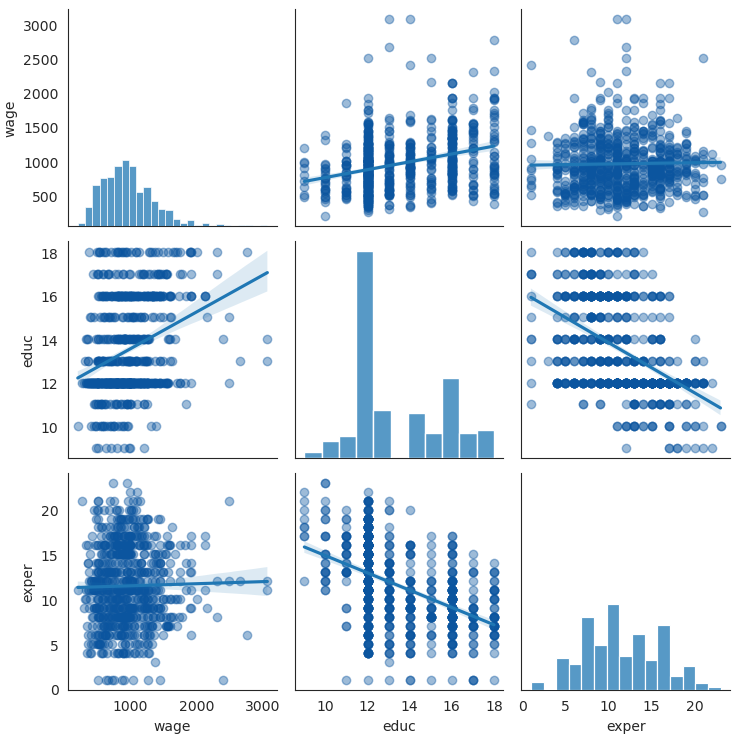

In [32]:

variables=['wage', 'educ', 'exper']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})
plt.tight_layout()

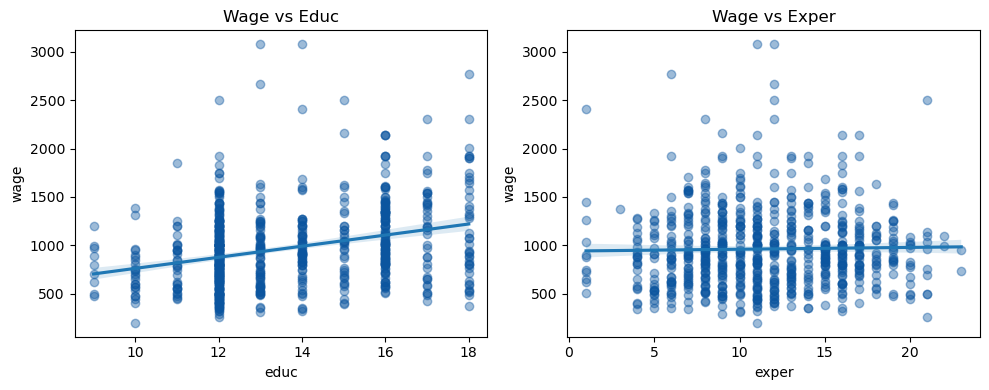

In [33]:
plt.figure(figsize=(10, 4))

# Top-middle: wage vs educ
plt.subplot(1, 2, 1)
sns.regplot(x='educ', y='wage', data=train,
            scatter_kws={'color': sns.color_palette('Blues')[-1], 'alpha': 0.4})
plt.title('Wage vs Educ')

# Top-right: wage vs exper
plt.subplot(1, 2, 2)
sns.regplot(x='exper', y='wage', data=train,
            scatter_kws={'color': sns.color_palette('Blues')[-1], 'alpha': 0.4})
plt.title('Wage vs Exper')

plt.tight_layout()
plt.show()

### LSA 2: Exogeneity

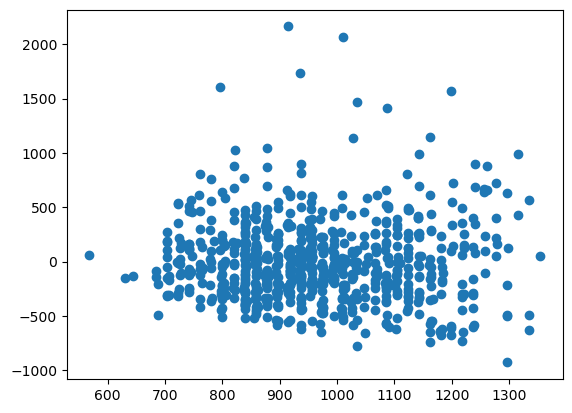

In [34]:
plt.scatter(t2_fit, t2_resid)
plt.show()

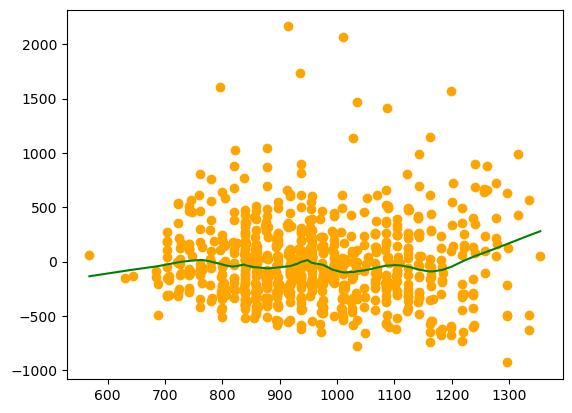

In [35]:
lowess = sm.nonparametric.lowess
plt.scatter(t2_fit, t2_resid, color='orange')
t2_z = lowess(t2_resid, t2_fit, frac=1./5)
plt.plot(t2_z[:,0],t2_z[:,1],'green')
plt.show()

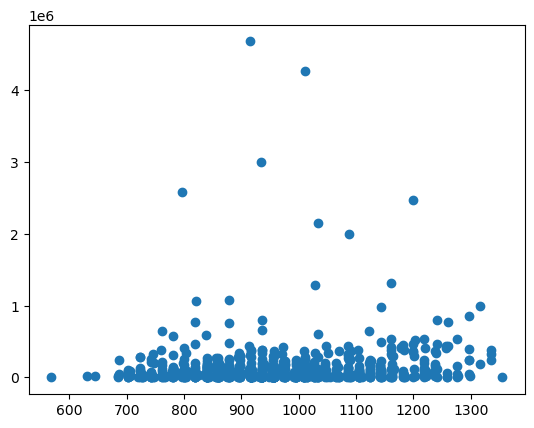

In [36]:
#Squared Residuals for MLR
t2_resid2=t2_reg.resid**2
plt.scatter(t2_fit, t2_resid2)
plt.show()

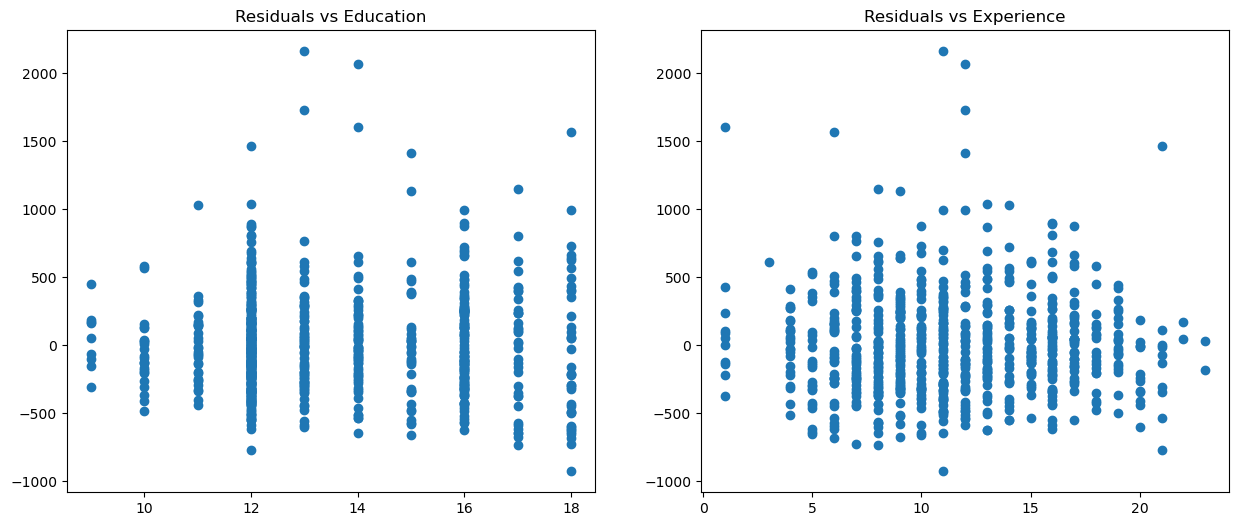

In [37]:
#Residuals against predictors
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(train['educ'], t2_resid)
ax1.set_title("Residuals vs Education")

ax2.scatter(train['exper'], t2_resid)
ax2.set_title("Residuals vs Experience")

plt.show()

### LSA 3: Data is IID

The data represent a cross-sectional survey of income earners, with each row corresponding to a distinct individual. Given that the observations are drawn independently from a population and reflect individual-level attributes, we assume the data satisfy LSA 3, the observations are independent and identically distributed.

### LSA 4: All 4th Moments Exist

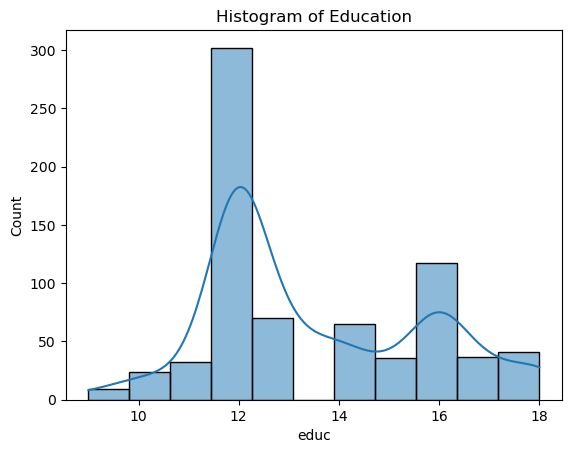

In [38]:
sns.histplot(train['educ'], kde=True)
plt.title("Histogram of Education")
plt.savefig('hist educ.png')
plt.show()

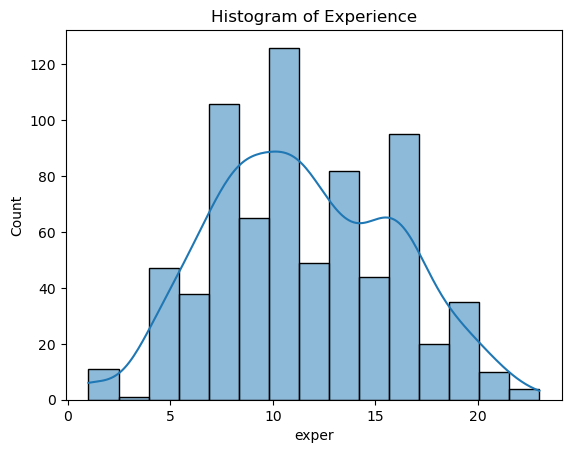

In [39]:
sns.histplot(train['exper'], kde=True)
plt.title("Histogram of Experience")
plt.savefig('hist exper.png')
plt.show()

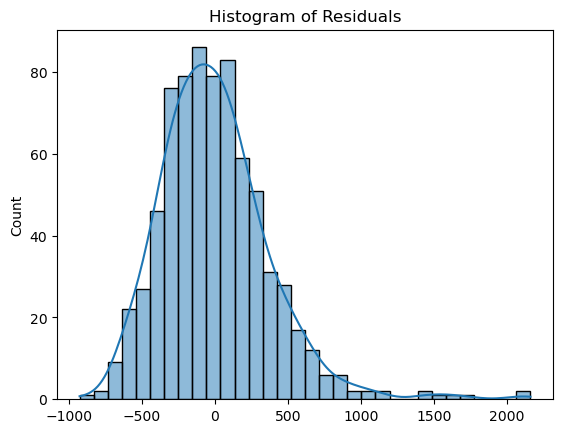

In [40]:
sns.histplot(t2_resid, kde=True)
plt.title("Histogram of Residuals")
plt.show()

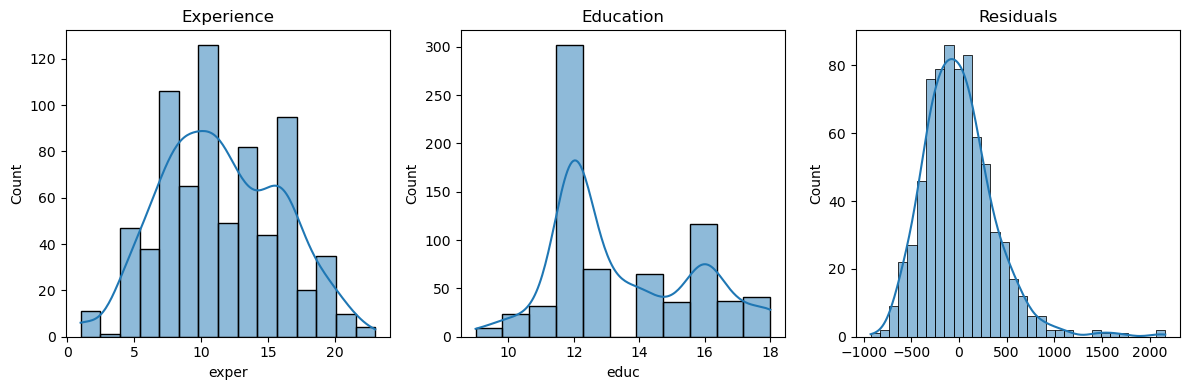

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

sns.histplot(train['exper'], kde=True, ax=axes[0])
axes[0].set_title("Experience")

sns.histplot(train['educ'], kde=True, ax=axes[1])
axes[1].set_title("Education")

sns.histplot(t2_resid, kde=True, ax=axes[2])  
axes[2].set_title("Residuals")

plt.tight_layout()
plt.savefig("lsa4_histograms.png", dpi=300, bbox_inches='tight')

### LSA 5: No Perfect Collinearity

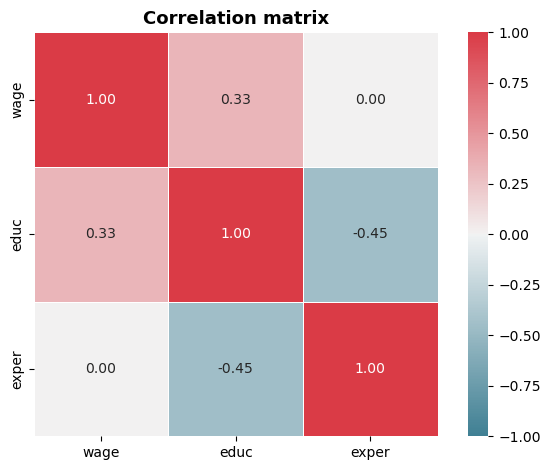

In [42]:
fig, ax = plt.subplots()
variables = ['wage', 'educ', 'exper']
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[variables].corr(), vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True, fmt='.2f', ax=ax, cmap=cmap)

ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('correlation matrix.png')
plt.show()

### LSA 6: Homoskedacity

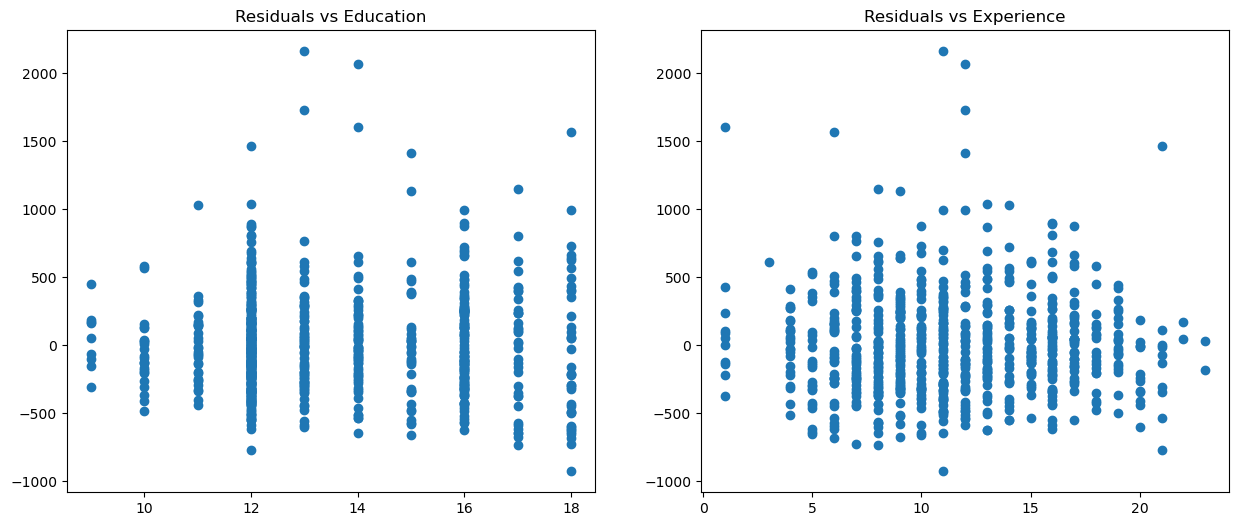

In [43]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(train['educ'], t2_resid)
ax1.set_title('Residuals vs Education')
ax2.scatter(train['exper'], t2_resid)
ax2.set_title('Residuals vs Experience')
plt.savefig('homoskedacity.png')
plt.show()

# **Task 3**

### Relationship between Wage and Education, and Wage and Experience ###

In [46]:
t3_slr_educ_model = smf.ols('wage ~ educ', data=train).fit()
t3_slr_educ_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     78.11
Date:                Mon, 19 May 2025   Prob (F-statistic):           7.21e-18
Time:                        16:16:40   Log-Likelihood:                -5399.0
No. Observations:                 733   AIC:                         1.080e+04
Df Residuals:                     731   BIC:                         1.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    188.8699     88.719      2.129      0.034      14.695     363.045
educ          57.3342      6.487      8.838      0.000      44.598      70.070
==============================================================================
Omnibus:                      179.416   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.454
Skew:                           1.179   Prob(JB):                    2.95e-120
Kurtosis:                       6.531   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
t2_slr_exper_model = smf.ols('wage ~ exper', data=train).fit()
t2_slr_exper_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3188
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.572
Time:                        16:16:40   Log-Likelihood:                -5436.0
No. Observations:                 733   AIC:                         1.088e+04
Df Residuals:                     731   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    941.2470     41.168     22.863      0.000     860.425    1022.069
exper          1.8868      3.342      0.565      0.572      -4.673       8.447
==============================================================================
Omnibus:                      186.803   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.904
Skew:                           1.275   Prob(JB):                    1.89e-111
Kurtosis:                       6.193   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **Task 4**

In [95]:
model = smf.ols('lwage ~ educ + exper + hours + age + urban', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     31.47
Date:                Mon, 19 May 2025   Prob (F-statistic):           4.69e-29
Time:                        17:33:01   Log-Likelihood:                -317.66
No. Observations:                 733   AIC:                             647.3
Df Residuals:                     727   BIC:                             674.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3235      0.191     27.835      0.000       4.948       5.699
educ           0.0725      0.007      9.708      0.000       0.058       0.087
exper          0.0163      0.004      3.862      0.000       0.008       0.025
hours         -0.0049      0.002     -2.488      0.013      -0.009      -0.001
age            0.0119      0.005      2.251      0.025       0.002       0.022
urban          0.1670      0.030      5.488      0.000       0.107       0.227
==============================================================================
Omnibus:                        8.494   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.616
Skew:                          -0.177   Prob(JB):                      0.00816
Kurtosis:                       3.436   Cond. No.                         804.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
model = smf.ols('lwage ~ educ + exper + hours + age + urban + hours:age + educ:urban', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     23.64
Date:                Mon, 19 May 2025   Prob (F-statistic):           5.04e-29
Time:                        17:33:44   Log-Likelihood:                -314.12
No. Observations:                 733   AIC:                             644.2
Df Residuals:                     725   BIC:                             681.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5851      0.917      8.268      0.000       5.784       9.386
educ           0.0608      0.012      4.895      0.000       0.036       0.085
exper          0.0164      0.004      3.896      0.000       0.008       0.025
hours         -0.0526      0.020     -2.609      0.009      -0.092      -0.013
age           -0.0522      0.028     -1.889      0.059      -0.106       0.002
urban         -0.0452      0.189     -0.239      0.811      -0.417       0.327
hours:age      0.0015      0.001      2.374      0.018       0.000       0.003
educ:urban     0.0154      0.014      1.105      0.270      -0.012       0.043
==============================================================================
Omnibus:                        7.384   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.711
Skew:                          -0.188   Prob(JB):                       0.0212
Kurtosis:                       3.332   Cond. No.                     9.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We use log wage instead of raw wage to improve both the accuracy and interpretability of the model. Taking the logarithm helps correct for the skewed distribution of wages and stabilizes the variance of the errors, which makes the regression assumptions more valid. It also allows us to interpret the coefficients in percentage terms, which is more intuitive 

We tested the interaction between age and hours worked (age:hours) to investigate whether the relationship between working hours and wage varies over the course of an individual’s life. This was motivated by the idea that older workers may experience different returns to work intensity than younger workers, for example, due to seniority, managerial roles, or flexible work arrangements.

This interaction was directly aligned with Goal (b), which is to build an optimal predictive model of wages. Including age:hours allowed us to test for nonlinear, real-world effects that could improve model accuracy. It turned out to be statistically significant and improved the model’s adjusted R² by 0.6, confirming that age meaningfully modifies the impact of hours worked on wage outcomes. Its inclusion improved the predictive performance and explanatory value of the model.

While working more hours is generally associated with lower log wages, possibly reflecting lower-paying or hourly work, the interaction shows that this negative association is weaker for older workers. This may reflect the fact that older individuals are more likely to hold senior, salaried, or managerial positions, where additional hours do not imply lower hourly wages and may even be better compensated.

We also tested educ:urban to examine whether the return to education differs by location, but this interaction was not statistically significant (p = 0.27). This indicates that, in our sample, the wage premium from education is fairly consistent across urban and non-urban settings.

The model explains approximately 17.8% of the variation in log-wage and supports the use of both main effects and limited interaction terms to balance predictive power and parsimony.